# La nuit

Calcul $h/M$ la nuit, entre 22h et 6h.

In [257]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

influxDB:  http://127.0.0.1:8083/  
Grafana: http://127.0.0.1:3000/dashboard/db/weatherdata?orgId=1

In [258]:
from influxdb import DataFrameClient

### Download the data

In [259]:
# see https://influxdb-python.readthedocs.io/en/latest/examples.html#tutorials-pandas
"""Instantiate the connection to the InfluxDB client."""

host, port = 'localhost', 8086
user, password = 'root', 'root'
dbname = 'weatherdata'
protocol = 'json' # 'line'

CLIENT = DataFrameClient(host, port, user, password, dbname)

In [245]:
d1 = '2017-11-05'

In [260]:
d1_DT = pd.to_datetime( d1 )
d2_DT = d1_DT + pd.to_timedelta('1d')

d1_DT = d1_DT.replace(hour=22)
d2_DT = d2_DT.replace(hour=6)

d1_DT = d1_DT.tz_localize('Europe/Paris')
d2_DT = d2_DT.tz_localize('Europe/Paris')

d1 = d1_DT.astimezone('UTC').strftime('%Y-%m-%d %H:%M:%S')
d2 = d2_DT.astimezone('UTC').strftime('%Y-%m-%d %H:%M:%S')

In [261]:
print( d1, d2 )

2017-11-05 21:00:00 2017-11-06 05:00:00


In [262]:
query = "SELECT T_int FROM openenergymonitor WHERE  time >= '%s' and time <= '%s'"%(d1, d2)
T_int_data = CLIENT.query(query)

query =  "SELECT temperature FROM darksky WHERE  time >= '%s' and time <= '%s'"%(d1, d2)
T_ext_data = CLIENT.query(query)

In [264]:
def toarray( DF ):
    data_dict = DF.to_dict(orient='list')
    time_sec = DF.index.astype(np.int64) // 1e9    # conversion en secondes
    
    time_sec = time_sec - time_sec[0]
    time_sec = time_sec / 3600
    data = [ k for k in data_dict.values() ][0]
    
    return time_sec, data

In [335]:
time_Tint, T_int = toarray( T_int_data['openenergymonitor'] )
time_Text, T_ext = toarray( T_ext_data['darksky'] )

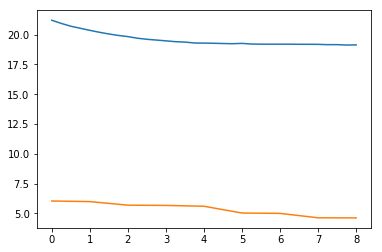

In [336]:
plt.plot( time_Tint, T_int )
plt.plot( time_Text, T_ext )

### Fit spline

In [269]:
from scipy.interpolate import UnivariateSpline

In [270]:
xnew = np.linspace( 0, time_Tint[-1], 200 )

In [271]:
spline = UnivariateSpline( time_Tint, T_int )

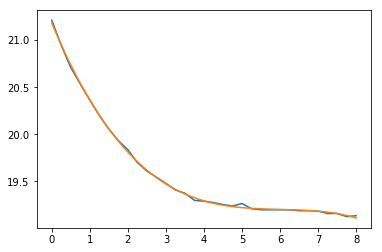

In [272]:
plt.plot( time_Tint, T_int )
plt.plot( xnew, spline( xnew ) )

In [30]:
spline.get_coeffs()

array([ 22.7409565 ,  22.53498413,  22.01844884,  21.73613475])

In [31]:
spline_dTdt = spline.derivative()

In [33]:
deltaT = T_ext - spline( time_Text )
dTdt = spline_dTdt( time_Text )

h_M = dTdt / deltaT

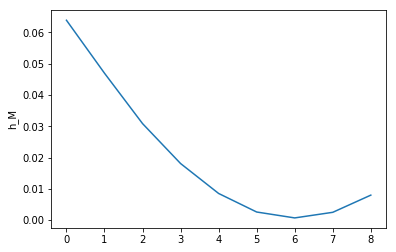

In [273]:
plt.plot( h_M );
plt.ylabel('h_M');

## iterate

In [296]:
# une fonction pour tout faire:
def get_hM( d1 ):
    d1_DT = pd.to_datetime( d1 )
    d2_DT = d1_DT + pd.to_timedelta('1d')

    d1_DT = d1_DT.replace(hour=22)
    d2_DT = d2_DT.replace(hour=6)

    d1_DT = d1_DT.tz_localize('Europe/Paris')
    d2_DT = d2_DT.tz_localize('Europe/Paris')

    d1 = d1_DT.astimezone('UTC').strftime('%Y-%m-%d %H:%M:%S')
    d2 = d2_DT.astimezone('UTC').strftime('%Y-%m-%d %H:%M:%S')
    
    
    query = "SELECT T_int FROM openenergymonitor WHERE  time >= '%s' and time <= '%s'"%(d1, d2)
    T_int_data = CLIENT.query(query)
    
    if not T_int_data:
        print('no data for %s'%d1)
        return np.array([]), np.array([])
    
    query =  "SELECT temperature FROM darksky WHERE  time >= '%s' and time <= '%s'"%(d1, d2)
    T_ext_data = CLIENT.query(query)
    
    time_Tint, T_int = toarray( T_int_data['openenergymonitor'] )
    time_Text, T_ext = toarray( T_ext_data['darksky'] )
    
    spline = UnivariateSpline( time_Tint, T_int )#, s=1.05 )
    spline_dTdt = spline.derivative()
    
    deltaT = T_ext - spline( time_Text )
    dTdt = spline_dTdt( time_Text )

    h_M = dTdt / deltaT
    
    #T_ext_data['darksky'].tz_convert('Europe/Paris')
    time_index = T_ext_data['darksky'].index
    return time_index, h_M
    

In [333]:
# debug:
get_hM( '2017-10-19' )

no data for 2017-10-19 20:00:00


(array([], dtype=float64), array([], dtype=float64))

In [334]:
# iterate : 
firstday = '2017-06-08'
lastday = '2017-11-05'

daterange = pd.date_range(start=firstday, end=lastday,  freq='D', normalize=True)
daterange_iso = daterange.strftime('%Y-%m-%d')

no data for 2017-06-08 20:00:00
no data for 2017-06-09 20:00:00
no data for 2017-06-10 20:00:00
no data for 2017-06-11 20:00:00
no data for 2017-06-12 20:00:00
no data for 2017-06-13 20:00:00
no data for 2017-06-14 20:00:00
no data for 2017-06-15 20:00:00
no data for 2017-06-16 20:00:00
no data for 2017-06-17 20:00:00
no data for 2017-06-18 20:00:00
no data for 2017-06-19 20:00:00
no data for 2017-06-20 20:00:00
no data for 2017-06-21 20:00:00
no data for 2017-06-22 20:00:00
no data for 2017-06-23 20:00:00
no data for 2017-06-24 20:00:00
no data for 2017-06-25 20:00:00
no data for 2017-06-26 20:00:00
no data for 2017-06-27 20:00:00
no data for 2017-06-28 20:00:00
no data for 2017-06-29 20:00:00
no data for 2017-10-18 20:00:00
no data for 2017-10-19 20:00:00
no data for 2017-10-20 20:00:00


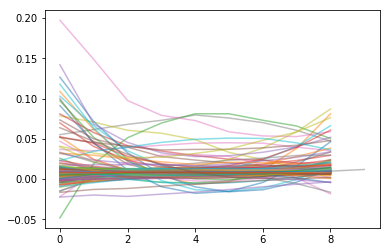

In [306]:
all_hM = []
for day in daterange_iso:
    time, h_M = get_hM( day )
    
    if len( h_M )>0:
        all_hM.append( h_M )
        plt.plot( h_M, alpha=0.5 )

In [312]:
all_hM = np.concatenate( all_hM )
all_hM = np.array( all_hM ).flatten()

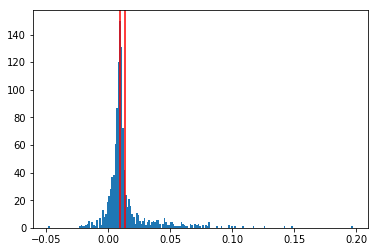

In [328]:
plt.hist(all_hM, bins='auto')  ;
plt.axvline(x=all_hM.mean(), color='r' );
plt.axvline(x=np.median( all_hM ), color='r' );

In [329]:
np.median( all_hM )

0.0096047327570730253

# -- Write to InfluxDB --

In [332]:
measurement_name = 'analyse'

for day in daterange_iso:
    time, h_M = get_hM( day )
    
    if len( time )==0:
        continue
        
    DF = pd.DataFrame( {'h_M':h_M}, index=time )
    
    # Ajoute colone par colones pour retirer les NaN...
    for c in DF.columns:
        CLIENT.write_points(DF[[c]].dropna(), measurement_name)

no data for 2017-06-08 20:00:00
no data for 2017-06-09 20:00:00
no data for 2017-06-10 20:00:00
no data for 2017-06-11 20:00:00
no data for 2017-06-12 20:00:00
no data for 2017-06-13 20:00:00
no data for 2017-06-14 20:00:00
no data for 2017-06-15 20:00:00
no data for 2017-06-16 20:00:00
no data for 2017-06-17 20:00:00
no data for 2017-06-18 20:00:00
no data for 2017-06-19 20:00:00
no data for 2017-06-20 20:00:00
no data for 2017-06-21 20:00:00
no data for 2017-06-22 20:00:00
no data for 2017-06-23 20:00:00
no data for 2017-06-24 20:00:00
no data for 2017-06-25 20:00:00
no data for 2017-06-26 20:00:00
no data for 2017-06-27 20:00:00
no data for 2017-06-28 20:00:00
no data for 2017-06-29 20:00:00
no data for 2017-10-18 20:00:00
no data for 2017-10-19 20:00:00
no data for 2017-10-20 20:00:00
